# CircuitCruncher: Circuit Simulation Analysis Tools
 - This repository contains Python scripts and modules to perform various analyses on circuit simulation data. The main functionalities include:
    - Make Spice Save File: Generates a SPICE save file for specified variables.
    - Operating Point Extraction: Extracts and displays operating point parameters of transistors.
    - AC Analysis Data Extraction: Extracts bode plot and main AC data  
<div class="alert alert-info" role="alert">
  <strong>Tip:</strong> For more information go to the Repo <a href="https://github.com/abdelrahmanali15/CircuitCruncher" class="alert-link">CircuitCruncher</a>.
</div>

***



## Guide to Open Locally on VSCode

You can also run the project through your browser, but if you prefer to work locally with VSCode, follow these steps:

### 1. Clone the Repository

First, download the repository. Open your terminal and run the following commands:

```bash
git clone https://github.com/abdelrahmanali15/CircuitCruncher/tree/try_notebook
cd CircuitCruncher
```

### 2. Open VSCode in the Repository

In the terminal, navigate to the cloned repository and open it in VSCode by running:

```bash
code .
```

### 3. Set Up the Environment

#### If you have Conda:
Create a conda environment using the provided YAML file:

```bash
conda env create -f environment.yaml
```

Activate the conda environment:

```bash
conda activate CircuitCruncher_env
```

#### If you don't have Conda:
Install the required packages using the requirements file:

```bash
pip install -r requirements.txt
```

### 4. Install VSCode Extensions

To work efficiently with Jupyter notebooks and data, install the following extensions in VSCode:

- **Jupyter Notebook Extension**: This allows you to open and run Jupyter notebooks directly in VSCode.
- **Data Wrangler Extension (optional)**: This extension helps with better variable reading and data manipulation.

To install these extensions, open VSCode and go to the Extensions view by clicking on the Extensions icon in the Activity Bar on the side of the window or by pressing `Ctrl+Shift+X`. Search for "Jupyter" and "Data Wrangler" and click `Install`.

---
### 5. Edit Jupyter Setting to Show Scrollable Outputs

Go to file > prefrences > settings. Search for `notebook.output.scrolling` in search bar and enable scrolling.
    

In [1]:
%reset -f

### Adding local library to path so it can be imported

In [2]:
import sys
sys.path.append('./lib')

In [3]:
from lib import * #import the all functions from local library
import numpy as np
import pandas as pd
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import yaml


### Add Simulation and Output Directories (User Configuration)

In [4]:

sim_dir = '/home/tare/XschemForSky/labs/lab2/mos-charc/sim'
save_raw_path = sim_dir +'/test_ota_tb.raw'
op_raw_path = sim_dir + '/test_ota_tb.raw'
ac_raw_path = sim_dir + '/ota-5t_tb2_ac.raw'
output_dir = '/home/tare/XschemForSky/Projects/ota-5t/xschem/output/'


### Generate Save Spice file for Operating point
        1. In your xschem testbench run op analysis, make sure to add `.options savecurrents` before your control block 
        2. Netlist and Simulate
        3. A Raw file contains currents is saved (its path and name should have been defined above)
        4. Load the Raw file and covert it to single data frame.
        5. Use function `save_fet_vars` to parse the data frame and return Save spice file
        6. Include the save spice file in xschem inside your control block by `.include /path/to/save.spi`
        7. Rerun the simulation
        8. Now all transistors parameters specified are saved in the new raw file

In [5]:

# Load YAML configuration from file
# loadConfig('config.yaml')

(arrs, plots) = ng_raw_read(save_raw_path)
OP_simNumber = simType('op',plots)


dfs = to_data_frames((arrs, plots))

df = dfs[OP_simNumber]  # Get the first DataFrame Assuming that it's the first analysis in the Raw File
# view_headers(df) # Print variables in dataframe to make sure that it's the one we need

save_file_name ='/save.spi'
saveVars = ['vgs','vds', 'vdsat', 'gm','gmbs', 'id', 'vth', 'gds','cgs'] # set variables to be saved in save.spi file
save_fet_vars(df.columns,saveVars,savefilename = sim_dir+save_file_name) # create save.spi file in sim directory 




Save file created successfully in /home/tare/XschemForSky/labs/lab2/mos-charc/sim/save.spi


## Include Save.spi file into your spice file and rerun the simulation to save variables needed

<div class="alert alert-danger" role="alert">
  <strong>Take care:</strong> Once used includeSaveSpice, the include is written in the spice file. Make sure you wrote the right dir and name of file </a>.
</div>

<div class="alert alert-info" role="alert">
  <strong>Tip:</strong> This only add to spice file, if you run `netlist` command from xschem it will overwrite it. If you want to make it persistant, copy the path of save file printed above into your control block in xschem</a>.
</div>



In [6]:
run_save = False
if run_save:
    ngconfig = {
        "ngspice": {
            "options": "-b"  # Example option, batch mode
        }
    }
    simulator = SpiceSimulator(
        name="test_ota_tb",
        simdir=sim_dir, #put sim dir where both spice file and save file are present
        config=ngconfig
    )


    simulator.includeSaveSpice(savedir=sim_dir,input_file='save.spi') #Put save file in the netlist
    simulator.ngspice()     # Rerun the simulation with save file included


### Print OP Parameters for all transistors

In [7]:
run_op = False
if run_op:    
    (arrs, plots) = ng_raw_read(op_raw_path)
    OP_simNumber = simType('op',plots)

    print(plots[OP_simNumber][b'plotname']) # Print Simulation type to make sure it's what we want


    dfs = to_data_frames((arrs, plots))
    df = dfs[OP_simNumber]  
    # view_headers(df) # Print variables in dataframe to make sure that it's the one we need


    # You can add variables other than default printed variables also add simple expresion of variables 
    op_sim(df,html=True,additional_vars=['cgs','gmbs','vgs'],custom_expressions={"Avi":"gm*ro"},output_file=output_dir+'dc_op') # Extract Transistors OP Data

### Extract AC Analysis Data 

In [8]:
run_ac = False
if run_ac:    
    (arrs, plots) = ng_raw_read(ac_raw_path)
    AC_simNumber = simType('ac',plots)

    dfs = to_data_frames((arrs, plots))
    df = dfs[AC_simNumber]

    # view_headers(df)

    ac_parameters = ac_analysis(df,save=True,output_file=output_dir+'ac_out')

    plt.show()

### This shows how to sweep parameter
1. you should run op analysis in a loop around parameter, ex control block

sweep l and save data, the function gets the data saved at each iteration and form a vector for it
it doesnt return l so you should add l vector in python code ex. l_values = np.arange(lcurrent, lstop , lstep)
```bash
.control 
 
.include /home/tare/XschemForSky/labs/lab2/mos-charc/sim/save.spi

let lcurrent = 0.15
let lstop = 10
let  lstep = 0.02

 while lcurrent le lstop
	alterparam l = $&lcurrent
	reset
	save all
	op
	let lcurrent = lcurrent + lstep
	write test_ota_tb.raw
	set appendwrite
end
```

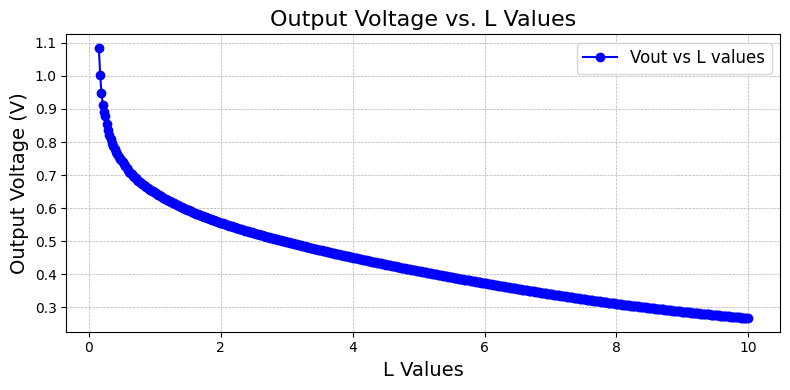

Size of l_values: 493
Size of vout: 493


In [12]:

(arrs, plots) = ng_raw_read("/home/tare/XschemForSky/labs/lab2/mos-charc/sim/test_ota_tb.raw")
dfs = to_data_frames((arrs, plots))

lcurrent = 0.15
lstop = 10
lstep = 0.02
l_values = np.arange(lcurrent, lstop , lstep)

vout = concatenate_op_dataframes(dfs, 'v(vout)')


plt.figure(figsize=(8, 6))  # Adjust the figure size

# Customize the plot
plt.plot(l_values, vout, marker='o', linestyle='-', color='b', label='Vout vs L values')
plt.title('Output Voltage vs. L Values', fontsize=16)
plt.xlabel('L Values', fontsize=14)
plt.ylabel('Output Voltage (V)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

# Print the sizes of l_values and vout
print('Size of l_values:', l_values.size)
print('Size of vout:', vout.size)
